<a href="https://colab.research.google.com/github/RBotL/Plant/blob/main/Final_Plant_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import cv2
import os
import seaborn as sns
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix
#from keras.preprocessing.image import ImageDataGenerator
import itertools

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#%cd drive/MyDrive/Plant

Mounted at /content/drive


In [7]:

!unzip -q "/content/drive/MyDrive/Plant/code_finalReport/New_Plant_disease_dataset.zip" -d "/content"

In [3]:
#Fetching the images for the train set
folder_path = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"

X_train=[]
y2_train=[]

width = 80
height = 80 # resize to 80x80 to solve the RAM issue 

for path, dirs, files in os.walk(folder_path):
    for file_name in dirs:
        files_path=folder_path+file_name
        for images in os.listdir(files_path):
            img=cv2.imread(files_path+'/'+images, cv2.IMREAD_COLOR)
            img_resized = cv2.resize(img, (width,height))
            X_train.append(np.array(img_resized)) 
            y2_train.append(file_name.split('___')[1]) #disease

In [4]:
#Fetching the images for the test set
folder_path = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/"

X_test=[]
y2_test=[]

width = 80
height = 80 # resize to 80x80 to solve the RAM issue 

for path, dirs, files in os.walk(folder_path):
    for file_name in dirs:
        files_path=folder_path+file_name
        for images in os.listdir(files_path):
            img=cv2.imread(files_path+'/'+images, cv2.IMREAD_COLOR)
            img_resized = cv2.resize(img, (width,height))
            X_test.append(np.array(img_resized))
            y2_test.append(file_name.split('___')[1]) #disease

In [5]:
# Transfoming the lists into arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

#Setting type float16 to use less memmory
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')

# Normalizing the data
X_train = X_train / 255
X_test = X_test / 255

In [6]:
# Getting the binary lables: 0 - healthy, 1 - disease
y_train = [0 if x == 'healthy' else 1 for x in y2_train]
y_test = [0 if x == 'healthy' else 1 for x in y2_test]

# Transforming the labels list into arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

del(y2_train, y2_test)

In [27]:
# Plotting functions

def plot_loss_accuracy(history, title=None):
    """
    Plots two graphs - loss per epoch and accuracy per epoch

    :param history: takes in a model history
    :param title: takes in a string for title of the plot
    """
    plt.figure(figsize=(12,4))
    plt.suptitle(title)
    plt.subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss by epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='right')
    
    plt.subplot(122)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model acc by epoch')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='right');

def plot_cm(y_true, y_pred, title=None):
    '''
    Plots a confusion matrix

    :param y_true: takes in the true labels of the dataset
    :param y_pred: takes in the predicted labels for the dataset
    :param title: takes in a string for title of the plot
    '''
    cnf_matrix = confusion_matrix(y_true, y_pred)

    classes = range(0,2)
    plt.figure(figsize=(5, 5))


    plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                horizontalalignment="center",
                color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

    plt.yticks([0,1],['Healthy', 'Sick'])
    plt.ylabel('Real labels')
    plt.xticks([0,1],['Healthy', 'Sick'],
                      rotation = 90)

    plt.xlabel('Predicted labels')
    plt.show()


def plot_errors(y_pred_model, y_pred_class, X, y_true):
    """
    Plots 9 random images that were labeled incorrectly

    :param y_pred_model: Takes in the the predictions generated by a model
    :param y_pred_class: Takes in the the prediction classes generated by a model
    :param X: Takes in the images
    :param y_true: Takes in the true labels of the images
    """
    plt.subplots(3, 3, figsize=(12, 12))
    error_indexes = []
    map = {0:'Healthy', 1:'Sick'}
    y_label = [map[i] for i in y_true]
    y_pred_label = [map[i] for i in y_pred_class]
    for i in range(len(y_pred_model)):
        if (y_pred_class[i] != y_true[i]):
          error_indexes += [i]

    j = 1
    for i in np.random.choice(error_indexes, size = 9):
        img = X[i] 
        #img = img.reshape(100, 100,3)
        plt.subplot(3, 3, j)
        j = j + 1
        plt.axis('off')

        plt.imshow(img,cmap = cm.binary, interpolation='None')
        plt.title('+ Label: ' + str(y_label[i]) \
                  + '\n' + 'Prediction label: '+ str(y_pred_label[i]) \
                  + '\n' + 'Prediction: '+ str(round(y_pred_model[i][0], 4)))



In [8]:
# Lenet model
# Last Dense layer activation function changed to sigmoid

from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf

model_le = Sequential()

model_le.add(Conv2D(filters = 128,
                     input_shape = (80,80,3),
                     kernel_size = (5,5),
                     activation = 'relu'))

model_le.add(MaxPooling2D(pool_size = (2, 2)))

model_le.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))

model_le.add(MaxPooling2D(pool_size = (2, 2)))

model_le.add(Dropout(rate = 0.2))

model_le.add(Flatten())

model_le.add(Dense(units = 128,
                    activation = 'relu'))

model_le.add(Dense(units = 1,
                     activation='sigmoid'))

model_le.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_le_history = model_le.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=[X_test, y_test])

Epoch 1/20
2197/2197 [==============================] - 54s 20ms/step - loss: 0.3564 - accuracy: 0.8312 - val_loss: 0.1990 - val_accuracy: 0.9154
Epoch 2/20
2197/2197 [==============================] - 41s 18ms/step - loss: 0.1826 - accuracy: 0.9263 - val_loss: 0.1350 - val_accuracy: 0.9454
Epoch 3/20
2197/2197 [==============================] - 41s 19ms/step - loss: 0.1186 - accuracy: 0.9554 - val_loss: 0.1162 - val_accuracy: 0.9597
Epoch 4/20
2197/2197 [==============================] - 41s 19ms/step - loss: 0.0795 - accuracy: 0.9704 - val_loss: 0.0851 - val_accuracy: 0.9682
Epoch 5/20
2197/2197 [==============================] - 41s 19ms/step - loss: 0.0600 - accuracy: 0.9779 - val_loss: 0.0604 - val_accuracy: 0.9776
Epoch 6/20
2197/2197 [==============================] - 41s 19ms/step - loss: 0.0443 - accuracy: 0.9840 - val_loss: 0.1109 - val_accuracy: 0.9617
Epoch 7/20
2197/2197 [==============================] - 41s 19ms/step - loss: 0.0367 - accuracy: 0.9869 - val_loss: 0.0691 -

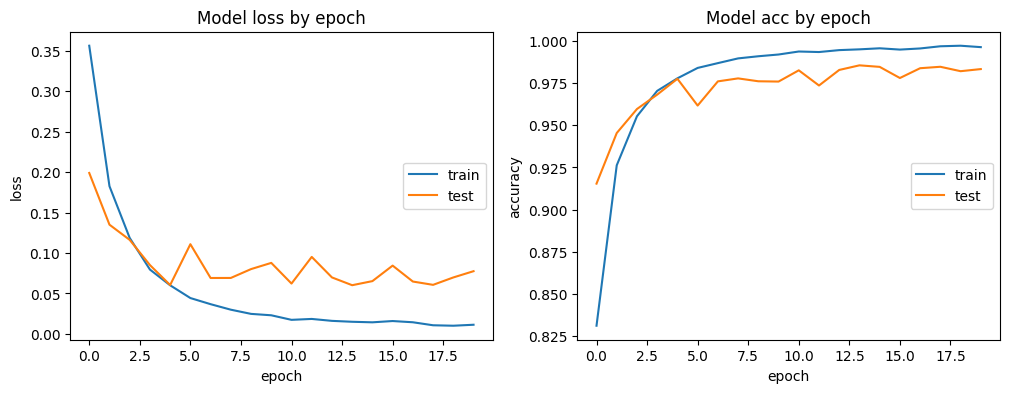

In [9]:
# Plotting the loss and accuracy per epoch graphs 
plot_loss_accuracy(model_le_history)

In [11]:
# Predicting the plants of the test set
y_pred_model_le = model_le.predict(X_test)

# Getting the Plant with highest probabilty 
y_pred = [0 if x <= 0.5 else 1 for x in y_pred_model_le]

# Classification report
print(classification_report(y_test, y_pred))

# confusion matrix 
#pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predicted'])

550/550 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5572
           1       0.99      0.99      0.99     12000

    accuracy                           0.98     17572
   macro avg       0.98      0.98      0.98     17572
weighted avg       0.98      0.98      0.98     17572



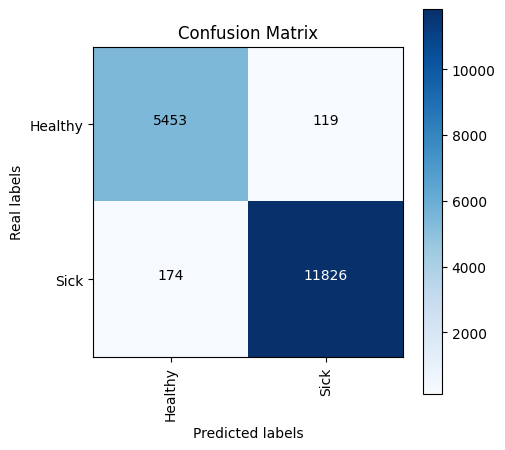

In [12]:
# Plotting the confusion matrix
plot_cm(y_test, y_pred, title='Confusion Matrix')

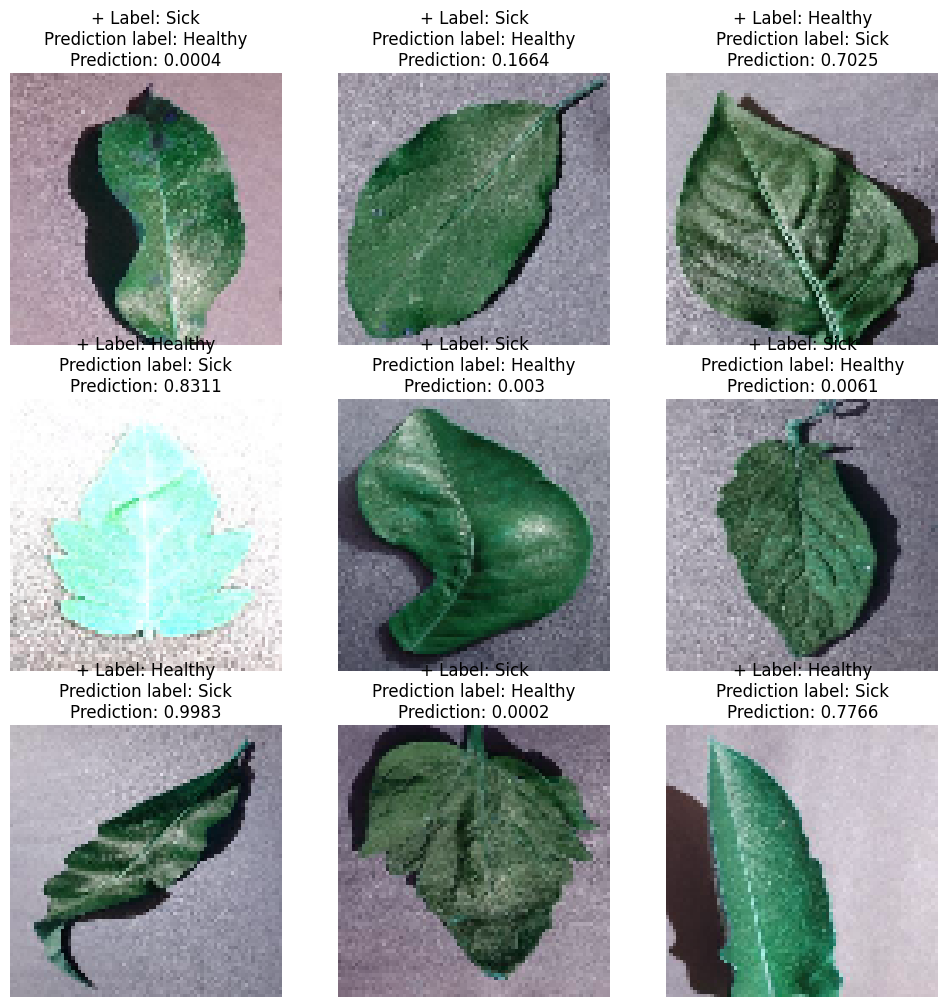

In [28]:
# Plotting images that were labeled incorrectly
plot_errors(y_pred_model_le, y_pred, X_test, y_test)

In [31]:
# CNN for binary classification 
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf

model_1 = Sequential()

model_1.add(Conv2D(filters = 16,
                     input_shape = (80,80,3),
                     kernel_size = (3,3),
                     activation = 'relu'))

model_1.add(MaxPooling2D(pool_size = (2, 2)))

model_1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))

model_1.add(MaxPooling2D(pool_size = (2, 2)))

model_1.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))

model_1.add(MaxPooling2D(pool_size = (2, 2)))

model_1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))

model_1.add(MaxPooling2D(pool_size = (2, 2)))

model_1.add(Dropout(rate = 0.2))

model_1.add(Flatten())

model_1.add(Dense(units = 512,
                    activation = 'relu'))

model_1.add(Dense(units = 1,
                     activation='sigmoid'))

model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_1_history = model_1.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
2197/2197 [==============================] - 24s 10ms/step - loss: 0.2256 - accuracy: 0.9015 - val_loss: 0.1102 - val_accuracy: 0.9579
Epoch 2/20
2197/2197 [==============================] - 17s 7ms/step - loss: 0.1056 - accuracy: 0.9593 - val_loss: 0.0914 - val_accuracy: 0.9640
Epoch 3/20
2197/2197 [==============================] - 17s 8ms/step - loss: 0.0787 - accuracy: 0.9703 - val_loss: 0.0540 - val_accuracy: 0.9799
Epoch 4/20
2197/2197 [==============================] - 16s 7ms/step - loss: 0.0639 - accuracy: 0.9760 - val_loss: 0.0624 - val_accuracy: 0.9761
Epoch 5/20
2197/2197 [==============================] - 16s 7ms/step - loss: 0.0537 - accuracy: 0.9806 - val_loss: 0.0420 - val_accuracy: 0.9848
Epoch 6/20
2197/2197 [==============================] - 16s 7ms/step - loss: 0.0464 - accuracy: 0.9827 - val_loss: 0.0417 - val_accuracy: 0.9847
Epoch 7/20
2197/2197 [==============================] - 17s 8ms/step - loss: 0.0407 - accuracy: 0.9851 - val_loss: 0.0368 - val_a

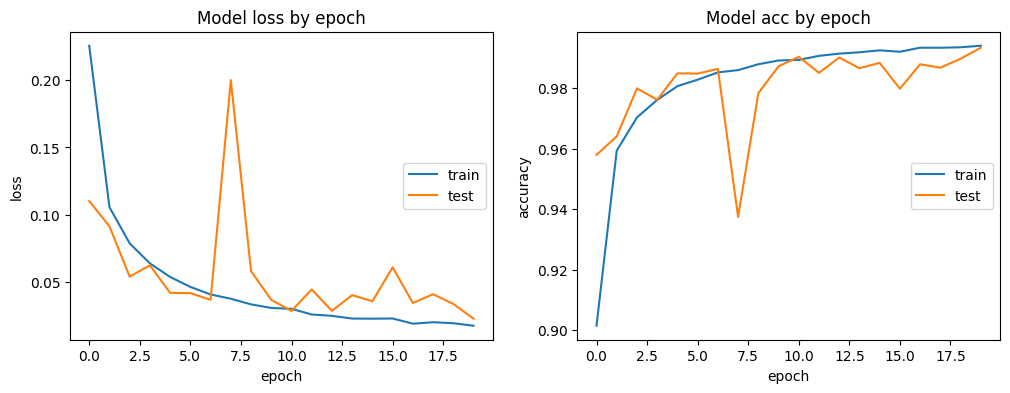

In [32]:
# Plotting the loss and accuracy per epoch graphs 
plot_loss_accuracy(model_1_history)

In [33]:
# Predicting the plants of the test set
y_pred_model_1 = model_1.predict(X_test)

# Getting the Plant with highest probabilty 
y_pred = [0 if x <= 0.5 else 1 for x in y_pred_model_1]

# Classification report
print(classification_report(y_test, y_pred))

# confusion matrix 
#pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predicted'])

550/550 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5572
           1       1.00      0.99      1.00     12000

    accuracy                           0.99     17572
   macro avg       0.99      0.99      0.99     17572
weighted avg       0.99      0.99      0.99     17572



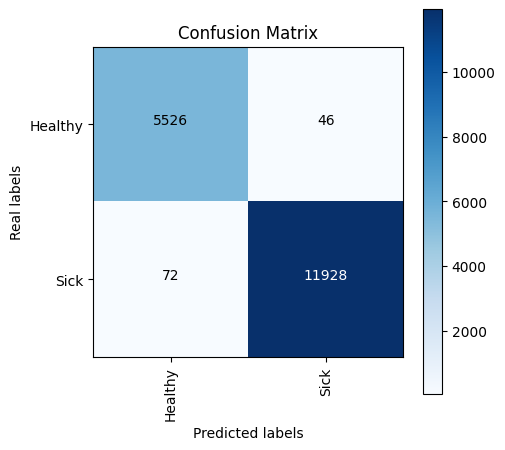

In [34]:
# Plotting the confusion matrix
plot_cm(y_test, y_pred, title='Confusion Matrix')

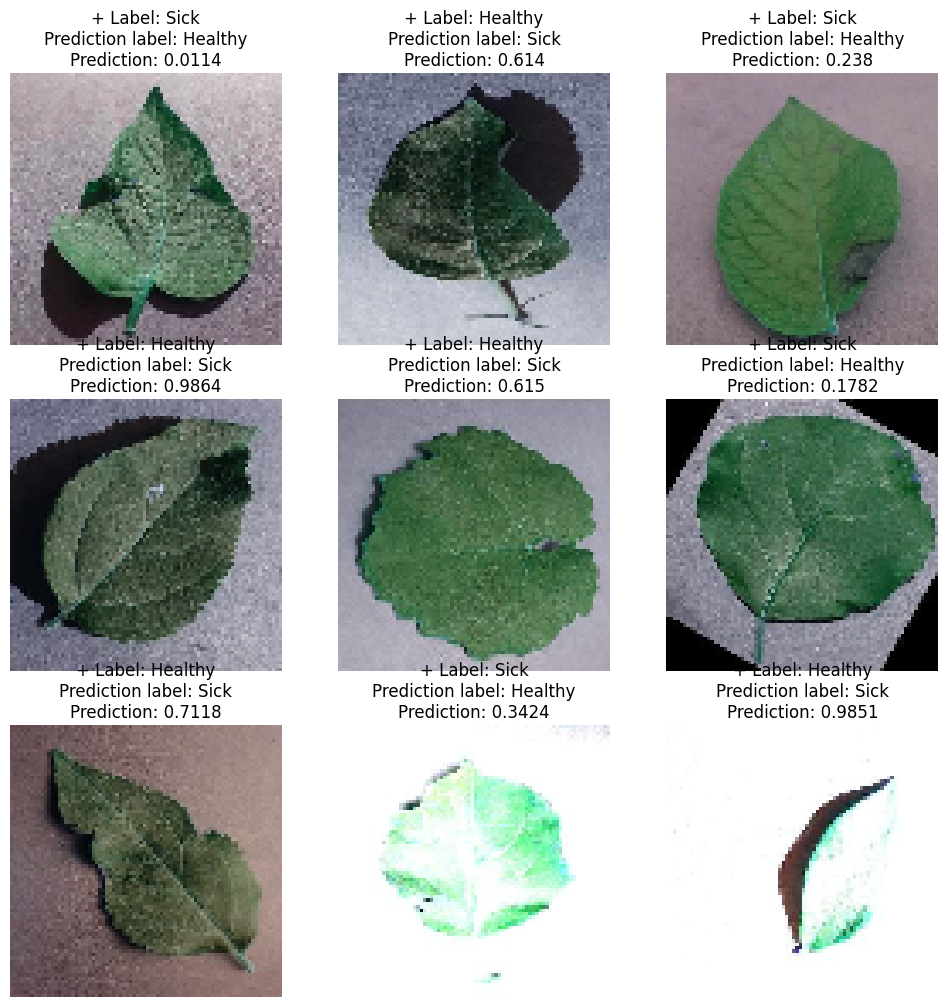

In [35]:
# Plotting images that were labeled incorrectly
plot_errors(y_pred_model_1, y_pred, X_test, y_test)